# Bayesian MBG estimation

## Geostatistical Modeling

In [1]:
import pymc as pm
#import aesara.tensor as at
#from aesara.graph.basic import Constant
import os
import pickle
import numpy as np
import arviz as az
import pandas as pd


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
import pytensor.tensor as at
import functions

import uuid

In [2]:
# Get the number of CPU cores to max out the machine in the traning stage
num_cores = os.cpu_count()

print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 8


### Parameters

In [3]:
#Load report
with open('temp_files/report/report.pkl', 'rb') as pickle_file:
    report = pickle.load(pickle_file)

In [4]:
report

{'Country': 'KHM',
 'DHS survey year': 2021,
 'Target Indicator': 'mpi_0',
 'Urban-rural threshold': 25,
 'DHS clusters before urban masking': 709,
 'Grids before masking': 7793,
 'CRS': 'WGS 84',
 'Grids after masking': 7667,
 'DHS clusters after masking': 660,
 'Grids with multiple clusters': 44,
 'Covariates before filtering': 215,
 'Covariates after filtering by -+ 1y': 66,
 'Variogram Range': 0.12051976764091166,
 'Suggested ls beta': 2.0,
 'Covariates after square and square-root transforms': 61,
 'Covariates after pairwise interactions': 1891,
 'Target mean pre transform': 0.19891632676043502,
 'Target std pre transform': 0.08742369759699463,
 'Transformation Applied': 'sqrt',
 'Lambda': None,
 'Number of covariates selected after Lasso': 15}

In [5]:
target_indicator = report['Target Indicator']

In [6]:
#Define the directory where the pickle files are stored
pickle_dir = 'temp_files'

### Load the target and the covariates

In [7]:
gdf = pd.read_pickle('temp_files/selected_features.pkl')

In [8]:
# Extract coordinates from the geometry column (using centroid for Polygons)
coordinates = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry])

# Extract coordinates from the geometry column (using centroid for Polygons) only for observed rows
coordinates_observed = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[~gdf[target_indicator].isnull()].geometry])

# Extract coordinates from the geometry column (using centroid for Polygons) only for unobserved rows
coordinates_unobserved = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[gdf[target_indicator].isnull()].geometry])

In [9]:
#Drop geometry
df = gdf.drop('geometry', axis=1)

In [10]:
#Only rows with observed target indicator
df1 = df[~df[target_indicator].isnull()]

In [11]:
#Save sampled df1 for next notebook
with open('temp_files/report/df1_sample.pkl', 'wb') as pickle_file:
    pickle.dump(df1, pickle_file)

### Transform the target indicator

In [12]:
## Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(df1[[target_indicator]])

## Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target
report['Lambda'] = lmda #Store lambda variable for some reversion processes

## Replace target for target_transformed in the df
df1[target_indicator] = target_transformed

Skewness: 0.9808429186805772, Kurtosis: 0.9394398422399473
Applying square root transformation due to moderate positive skewness.


/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_93362/538854860.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[target_indicator] = target_transformed


In [13]:
selected_features = df1.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'grid_id']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [14]:
# Covariate matrix
X = df1[selected_features].values

# Series with the target variable observed
response = df1[target_indicator].values

In [15]:
#Store the mean and the std for inverse transformation
report['Target mean'] = response.mean()
report['Target std'] = response.std()

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaler_y = StandardScaler()
response = scaler_y.fit_transform(response.reshape(-1, 1)).flatten()

In [18]:
#Standarize the coordinates
# Initialize the StandardScaler
scaler_coordinates = StandardScaler()

# Standardize the coordinates
coordinates_observed = scaler_coordinates.fit_transform(coordinates_observed)

In [19]:
report['Observations used to train the model'] = response.shape[0]

### Bayesian Model Training

Key Components of the Model

    Priors:
        beta: Coefficients for the linear model, assumed to follow a normal distribution with mean 0 and standard deviation 1.
        sigma: Standard deviation of the observation noise, assumed to follow a half-normal distribution with standard deviation 1.
        ls: Length-scale parameter for the spatial covariance function, assumed to follow a half-Cauchy distribution with scale parameter 1.

    Spatial Distance Matrix:
        D: Matrix of Euclidean distances between all pairs of observed locations.

    Covariance Function:
        K: Covariance function (Matern 5/2) which defines the spatial correlation structure.

    Gaussian Process (GP):
        gp: Latent Gaussian process with the defined covariance function.
        f: Prior distribution of the GP evaluated at the observed coordinates.

    Linear Model:
        mu: Mean of the linear model which is a combination of the linear predictor (X * beta) and the spatial effect (f).
        y_obs: Observed responses, modeled as a normal distribution with mean mu and standard deviation sigma.

    Inference:
        Using Automatic Differentiation Variational Inference (ADVI) to approximate the posterior distribution of the model parameters.
        advi_fit: Fitting the model using ADVI.
        trace: Sampling from the fitted model to obtain posterior samples.

In [20]:
print(f'Observations to train on {response.shape[0]}')

Observations to train on 449


In [21]:
report['Variogram Range']

0.12051976764091166

In [22]:
%%time
# Fit a Bayesian geostatistical model
with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=report['Target mean'], sigma=report['Target std'], shape=len(selected_features))
    #beta = pm.Normal('beta', mu=0, sigma=1, shape=len(selected_features))
    #sigma = pm.HalfNormal('sigma', sigma=report['Target std'])
    sigma = pm.HalfNormal('sigma', sigma=1)
    
   #ls = pm.HalfCauchy('ls', beta=report['Suggested ls beta'])

    ls = pm.HalfCauchy('ls', beta=report['Variogram Range'])

    print('Priors run')

    # Spatial distance matrix
    D = np.sqrt(((coordinates_observed[:, None, :] - coordinates_observed[None, :, :])**2).sum(axis=-1))

    print('Distance matrix calculated')

    # Define covariance function
    K = pm.gp.cov.Matern52(2, ls=ls)
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=coordinates_observed)

    print('Covariance run')

    # Linear model
    ## This defines the mean of the normal distribution for the observed data. It combines a linear regression term (pm.math.dot(X, beta)) with the GP latent function f.
    mu = pm.math.dot(X, beta) + f

    ## This defines the likelihood of the observed data (response) as a normal distribution with mean mu and standard deviation sigma.
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=response)

    print('Linear model specified')

    # Inference
    step = pm.NUTS(target_accept=0.95)
    idata = pm.sample(1000, tune=1000, step=step, cores=num_cores, return_inferencedata=True) #The num_cores parameter maxes the machine out. Tweak if needed. 

    print('Model Fitted')


Priors run
Distance matrix calculated
Covariance run
Linear model specified


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [beta, sigma, ls, f_rotated_]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 12907 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model Fitted
CPU times: user 57min, sys: 2min 24s, total: 59min 24s
Wall time: 3h 35min 17s


In [23]:
#az.to_netcdf(idata, trace_filename)

## Testing the model results

1. Posterior Predictive Checks
2. Prediction Accuracy Metrics
3. Residual Analysis
4. Uncertainty Quantification

### Posterior Predictive Checks:

Posterior Predictive Distribution: Compare the observed data to the posterior predictive distribution of the model. This involves generating new data based on the posterior distributions of the model parameters and comparing these simulated data to the actual observations.


Sampling: [y_obs]


Output()

/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


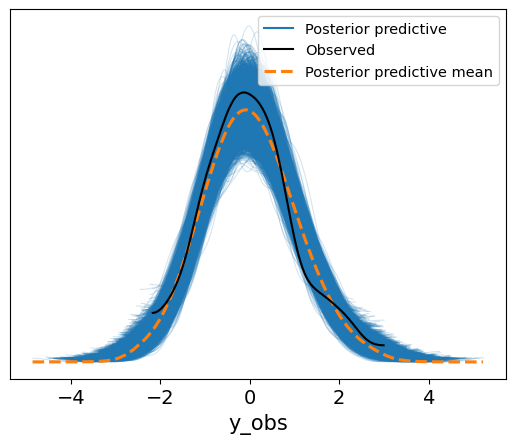

In [24]:
# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Plot posterior predictive checks
az.plot_ppc(posterior_predictive, kind='kde', data_pairs={'y_obs': 'y_obs'})

# Show the plot
plt.show()

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

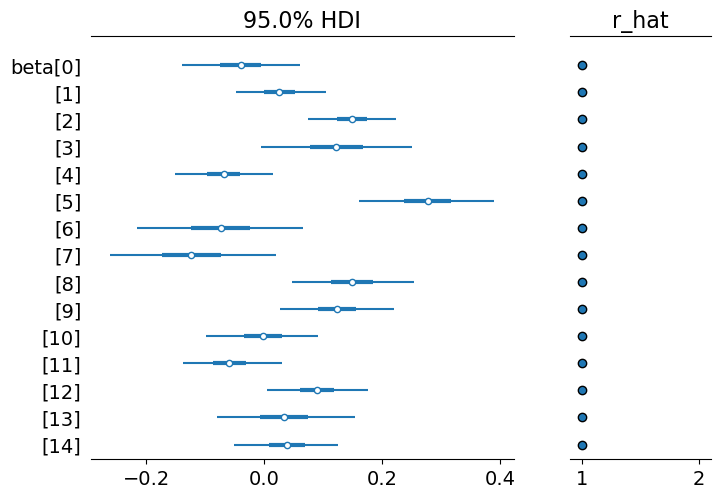

In [25]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)

#### Trace plots

Interpretation of Trace Plots

    Density Plots (Left Column):
        Each subplot on the left shows the kernel density estimate of the posterior distribution for a parameter.
        These plots give an idea of the central tendency (mean or median) and the spread (variance) of the parameter estimates.
        For example, the density plot for beta shows multiple colored curves corresponding to different chains, indicating the posterior distributions of the coefficients.

    Trace Plots (Right Column):
        Each subplot on the right shows the sampled values of the parameter across iterations for each chain.
        These plots help in assessing the convergence of the Markov Chain Monte Carlo (MCMC) sampling.
        A good trace plot should look like a "hairy caterpillar," with the chains mixing well and no apparent trends or patterns over iterations.

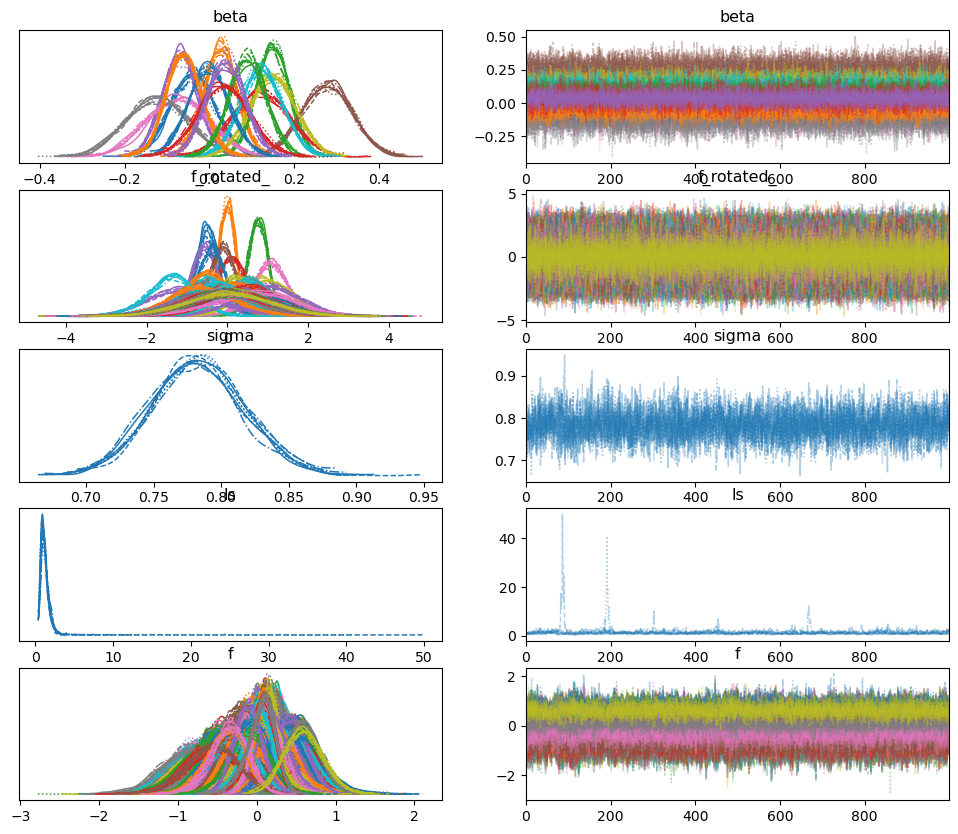

In [26]:
import matplotlib.pyplot as plt

# Generate the trace plot
trace_plot = az.plot_trace(idata)

# Save the plot to a file
plt.savefig('temp_files/report/9. trace_plot.pdf')

### Residual Analysis

#### Spatial Residual Plots 

Plot residuals (the differences between observed and predicted values) over the spatial domain to check for patterns. Randomly distributed residuals indicate a good fit.

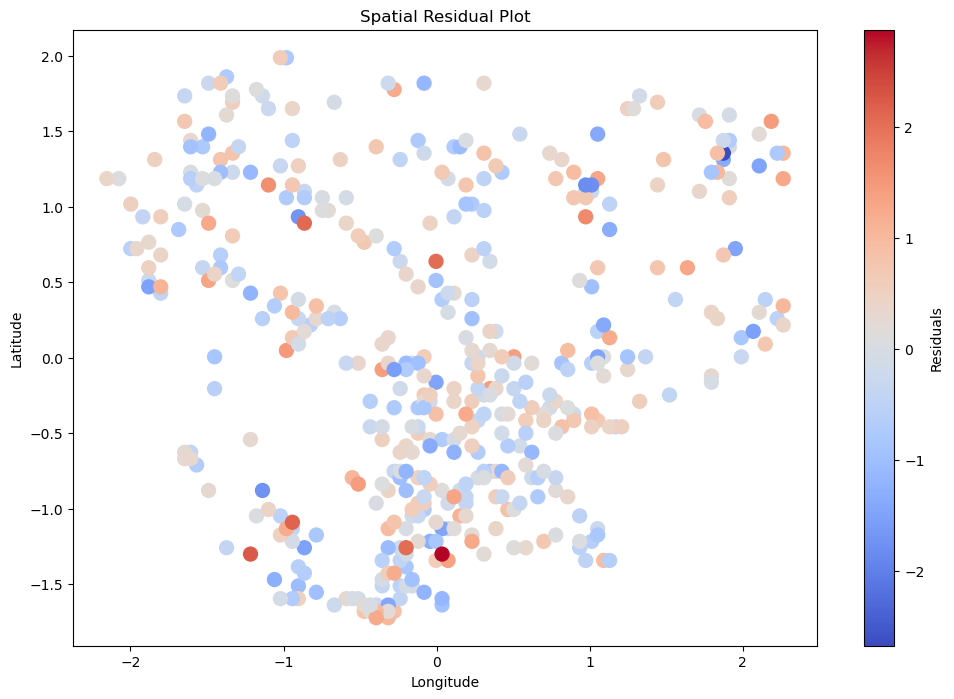

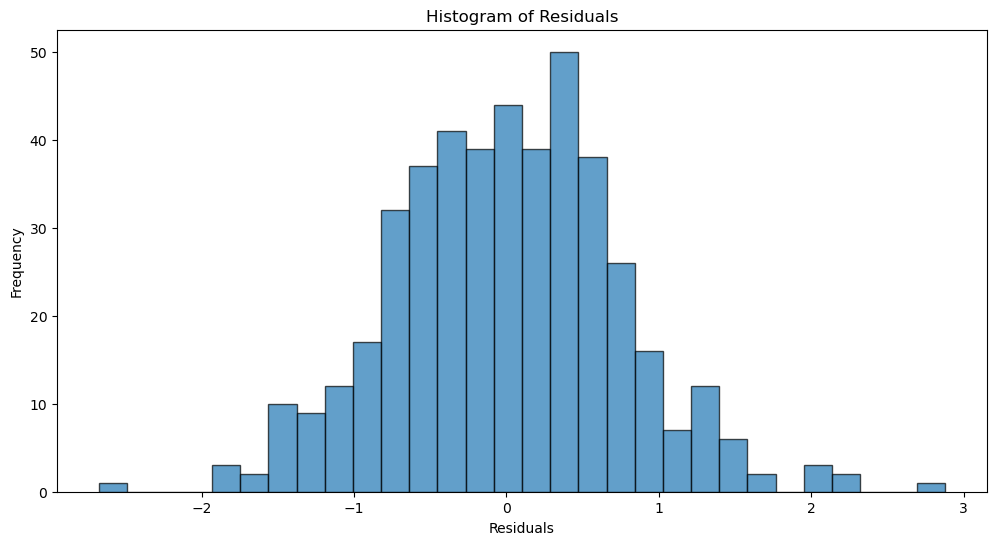

In [27]:
# Extract the observed data
y_obs = posterior_predictive.observed_data['y_obs'].values

# Calculate the mean of the simulated data across chains and draws
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=('chain', 'draw')).values

# Calculate residuals
residuals = y_obs - y_sim

# Plot spatial residuals
plt.figure(figsize=(12, 8))
sc = plt.scatter(coordinates_observed[:, 0], coordinates_observed[:, 1], c=residuals, cmap='coolwarm', s=100)
plt.colorbar(sc, label='Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Residual Plot')
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### Uncertainty Quantification

	•	Credible Intervals: Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.
	•	Uncertainty Maps: Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

#### Credible Intervals

Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.

Sampling: [y_obs]


Output()

Coverage of 95% Credible Intervals: 97.10%


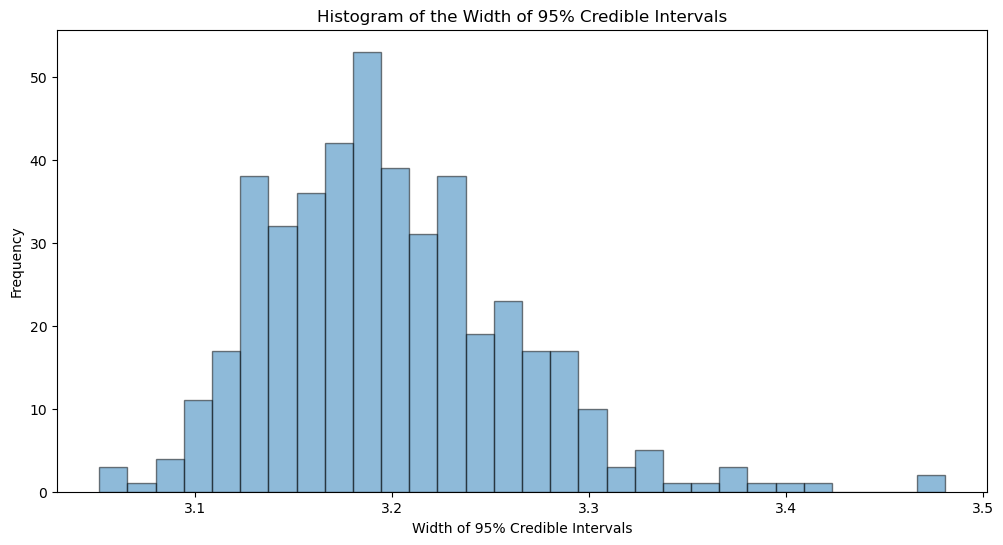

In [28]:
# Extract the observed and simulated data
y_obs = response

# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Extract the mean prediction, lower and upper bounds of the 95% credible intervals
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=("chain", "draw")).values
hdi = az.hdi(posterior_predictive.posterior_predictive, hdi_prob=0.95)['y_obs']

# Calculate the width of the credible intervals
ci_width = hdi[:, 1] - hdi[:, 0]

# Check how many true values are within the credible intervals
within_ci = np.sum((y_obs >= hdi[:, 0]) & (y_obs <= hdi[:, 1]))
total_obs = len(y_obs)
coverage = within_ci / total_obs

print(f"Coverage of 95% Credible Intervals: {coverage * 100:.2f}%")



# Plot the width of the credible intervals
plt.figure(figsize=(12, 6))
plt.hist(ci_width, bins=30, edgecolor='k', alpha=0.5)
plt.xlabel('Width of 95% Credible Intervals')
plt.ylabel('Frequency')
plt.title('Histogram of the Width of 95% Credible Intervals')
plt.show()

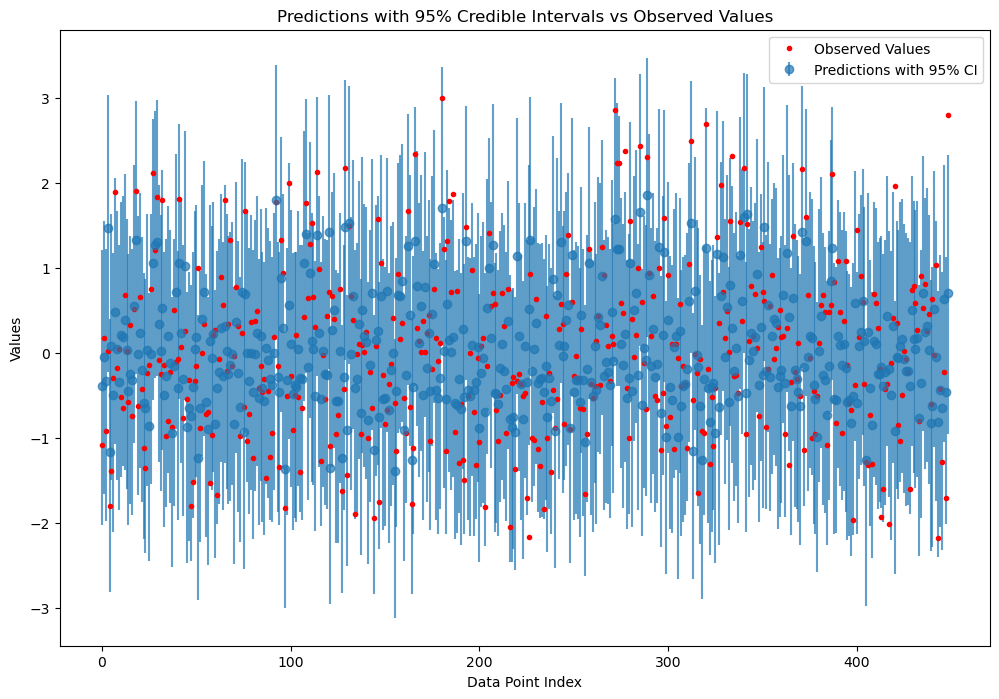

In [29]:
# Plot the credible intervals vs the observed values
plt.figure(figsize=(12, 8))
plt.errorbar(np.arange(len(y_obs)), y_sim, yerr=[y_sim - hdi[:, 0], hdi[:, 1] - y_sim], fmt='o', alpha=0.7, label='Predictions with 95% CI')
plt.plot(np.arange(len(y_obs)), y_obs, 'r.', label='Observed Values')
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Predictions with 95% Credible Intervals vs Observed Values')
plt.legend()
plt.show()

### Transform the results back to original scale

#### Revert observed

In [30]:
y_denormalized = functions.revert_standardization(response, report['Target mean'], report['Target std'])

In [31]:
y_original_scale = functions.revert_transformation(y_denormalized, 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

#### Revert predicted

In [32]:
y_sim_dn = functions.revert_standardization(y_sim, report['Target mean'], report['Target std'])

In [33]:
y_sim_original_scale = functions.revert_transformation(y_sim_dn, 
                                report['Transformation Applied'],
                                report['Target mean'], 
                                report['Target std'], 
                               report['Lambda']).round(4)

### Prediction Accuracy Metrics (at original scale)

#### Mean Absolute Error (MAE)

Measures the average magnitude of the errors in a set of predictions, without considering their direction.

In [34]:
# Calculate the absolute errors
absolute_errors = np.abs(y_original_scale - y_sim_original_scale)

# Calculate the Mean Absolute Error
mae = np.mean(absolute_errors)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.050564142538975496


In [35]:
report['Bayesian model MAE'] = mae

#### Root Mean Squared Error (RMSE) 

Measures the square root of the average of squared differences between predicted and observed values, providing an indication of the model’s overall error.

In [36]:
# Calculate the squared errors
squared_errors = np.square(y_original_scale - y_sim_original_scale)

# Calculate the Mean Squared Error (MSE)
mse = np.mean(squared_errors)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.0655860459315502


In [37]:
report['Bayesian RMSE'] = rmse

In [38]:
#Save report as pickle
with open('temp_files/report/report.pkl', 'wb') as pickle_file:
    pickle.dump(report, pickle_file)

In [39]:
bayesian_report_keys = ['Variogram Range',
                        'Transformation Applied', 
                        'Number of covariates selected after Lasso',  
                        'Observations used to train the model',
                        'Target mean', 
                        'Target std',
                        'Target mean pre transform',
                        'Target std pre transform',
                        'Bayesian model MAE', 
                        'Bayesian RMSE']

In [40]:
bayesian_report = {key: report[key] for key in bayesian_report_keys if key in report}

In [41]:
t1 = pd.DataFrame(data={'Data':bayesian_report.keys(), 
                  'Value': bayesian_report.values()}, 
             columns=['Data','Value'])

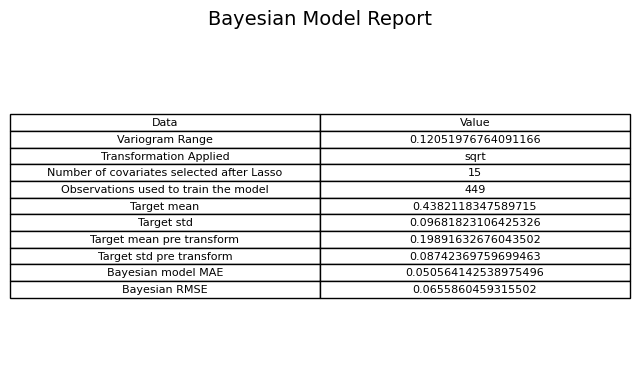

In [42]:
table_path = os.path.join('temp_files/report/', '14. Bayesian Report.pdf')
title = 'Bayesian Model Report'
functions.df_to_pdf(t1, table_path, title=title, show=True)

# Predictions

In [43]:
gdf = pd.read_pickle('temp_files/selected_features.pkl')
gdf_full = pd.read_pickle('temp_files/selected_features_full.pkl')

In [44]:
selected_features = gdf.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'grid_id']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [45]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Extract coordinates from the geometry column (using centroid for Polygons)
coordinates = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry])

#Standardize
coordinates = scaler.fit_transform(coordinates)

# Extract coordinates from the geometry column (using centroid for Polygons) only for observed rows
coordinates_observed = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf[~gdf[target_indicator].isnull()].geometry])

# Standardize
coordinates_observed = scaler.fit_transform(coordinates_observed)

In [46]:
#Only rows with observed target indicator
df1 = gdf[~gdf[target_indicator].isnull()]

In [47]:
# Select and apply the best transformation
target_transformed, transform, lmda = functions.select_transformation(df1[[target_indicator]])

#Store important information for reversion

report['Transformation Applied'] = transform #Transformation applied to target
report['Lambda'] = lmda #Store lambda variable for some reversion processes

Skewness: 0.9808429186805772, Kurtosis: 0.9394398422399473
Applying square root transformation due to moderate positive skewness.


In [48]:
#Replace target for target_transformed in the df
df1[target_indicator] = target_transformed

/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [49]:
# Transformed target variable
y = df1[target_indicator].values

In [50]:
# Covariate matrix
X = df1[selected_features].values

In [51]:
# Standardize features and transformed y

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [52]:
# Save the scaler to a pickle file
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

In [53]:
#DF with all observations
gdf2 = gdf_full.copy(deep=True) #This line to make predictions for all observations
#gdf2 = gdf2.sample(1000)
df2 = gdf2.copy(deep=True)
df2.reset_index(drop=True, inplace=True)

# Extract coordinates from the geometry column (using centroid for Pcolygons)
coordinates_new = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf2.geometry])

# Standardize
coordinates_new = scaler.fit_transform(coordinates_new)

# Covariate matrix
X_new = df2[selected_features].values

# Standardize the new data using the same scaler fitted on the observed data
X_new = scaler_x.transform(X_new)

In [54]:
begin_from_scratch = True
    
if begin_from_scratch == True: 
    #Dataframe to store predictions and other values for uncertainty calculations
    df3 = pd.DataFrame(df2[['grid_id', target_indicator]].head(0))
    start_position=0

else:
    #Pick-up productions were we left of. 
    with open('temp_files/predictions.pkl', 'rb') as pickle_file:
        df3 = pickle.load(pickle_file)
    start_position = df3.index.max() + 1

In [55]:
import scipy.stats as stats

In [56]:
# Assuming 95% confidence level, change alpha for different confidence levels
alpha = 0.05
z_score = stats.norm.ppf(1 - alpha/2)

In [57]:
#step = 434
step = 100

In [58]:
X_new.shape

(7667, 15)

In [59]:
# Step is the number of observations to select in each iteration
num_observations = len(X_new)
all_indices = np.arange(num_observations)

for i in range(start_position, num_observations, step):
    
    # Randomly select 'step' indices without replacement for each iteration
    if step <= len(all_indices):
        r = np.random.choice(all_indices, size=step, replace=False)
        all_indices = np.setdiff1d(all_indices, r)  # Remove the selected indices from the pool
    else:
        # If fewer than 'step' indices remain, select all remaining indices
        r = all_indices
        all_indices = np.array([])

    print(f"Remaining indices: {len(all_indices)}")

    # Select the subset of new data points for this batch
    X_new_i = X_new[r]
    coordinates_new_i = coordinates_new[r]

    # Generate a unique variable name for each iteration
    f_pred_name = "f_pred_" + str(uuid.uuid4())

    # Prediction generation using the Gaussian Process and posterior sampling
    with model:
        # Define the Gaussian Process covariance function for new points with jitter for numerical stability
        f_pred = gp.conditional(f_pred_name, Xnew=coordinates_new_i, jitter=1e-2)
    
        # Sampling from the posterior predictive distribution for the new data points
        ppc = pm.sample_posterior_predictive(idata, var_names=[f_pred_name], return_inferencedata=True)

    # Extract 'beta' samples from the original posterior (idata)
    beta_samples = idata.posterior['beta'].values  # Posterior samples for 'beta'

    # Extract GP samples from posterior predictive
    gp_samples = ppc.posterior_predictive[f_pred_name].values  # GP predictions

    # Check dimensions
    print(f"beta_samples shape: {beta_samples.shape}")  # Should be (num_samples, num_features)
    print(f"X_new_i shape: {X_new_i.shape}")            # Should be (num_points, num_features)

    # Calculate the linear component (dot product) for each sample
    # Make sure the dimensions match: (num_samples, num_features) @ (num_features, num_points)
    linear_component = np.dot(beta_samples, X_new_i.T)  # Shape: (num_samples, num_points)

    # Combine the GP predictions and linear component
    combined_predictions = gp_samples + linear_component

    # Create DataFrame for all posterior samples (1000 samples for each observation)
    dfpi = pd.DataFrame(combined_predictions.mean(axis=0))  # The shape should be (1000, num_points)

    # Extracting relevant data for the current batch
    dfi = df2.loc[r][['grid_id', target_indicator]]

    # Combine predictions with the data
    dfi[target_indicator] = dfpi.mean(axis=0).values  # Mean prediction across samples
    dfi['std'] = dfpi.std(axis=0).values               # Standard deviation across samples
    dfi['max'] = dfpi.max(axis=0).values               # Max prediction across samples
    dfi['min'] = dfpi.min(axis=0).values               # Min prediction across samples

    # Calculating the margin of error for the confidence interval
    dfi['standard_error'] = dfi['std'] / (len(dfpi)**0.5)
    dfi['margin_of_error'] = z_score * dfi['standard_error']

    # Calculating the confidence interval
    dfi['ci_lower'] = dfi[target_indicator] - dfi['margin_of_error']
    dfi['ci_upper'] = dfi[target_indicator] + dfi['margin_of_error']

    # Combine with previous results
    df3 = pd.concat([df3, dfi])

    # Save predictions so far
    dfpi.to_pickle('temp_files/dfpi.pkl')  # Save all predictions for the current batch
    df3.to_pickle('temp_files/predictions.pkl')

    # Break the loop if no more indices are left to process
    if len(all_indices) == 0:
        break


Remaining indices: 7567


Sampling: [f_pred_cb923221-8419-436a-8036-ad1c98b37c6b]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 7467


Sampling: [f_pred_c9da355c-bdb2-4b27-b295-5ab23e9ba14c]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 7367


Sampling: [f_pred_6bd85063-4572-40e9-9829-496dedc1bd7e]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 7267


Sampling: [f_pred_3c1a374a-4bfb-4a3e-9a54-27ebd1d817ac]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 7167


Sampling: [f_pred_738b1cd0-d83a-4932-943e-6ddac0bdf6e1]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 7067


Sampling: [f_pred_518f4615-2f70-40d8-b70f-14bbcff9475f]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6967


Sampling: [f_pred_5d536427-41be-4e37-9e53-9f45b127cc4f]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6867


Sampling: [f_pred_bc2b7b3f-de55-4b09-9c55-489599302251]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6767


Sampling: [f_pred_7bfe5c27-61ac-4031-9b7e-d048bf91a617]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6667


Sampling: [f_pred_3ac5e3d3-0768-4b53-9392-dfe761fb37e0]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6567


Sampling: [f_pred_05b9d822-3ded-4f59-a787-69d63388c2ee]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6467


Sampling: [f_pred_41e2df3d-c695-4cf6-acf1-86eba0dfb232]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6367


Sampling: [f_pred_4c1ebd90-89ab-4d2a-b719-2d2d575837ac]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6267


Sampling: [f_pred_bf4dcb24-f42d-4e55-8450-122fbf74c040]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6167


Sampling: [f_pred_02809ae3-e827-42bb-88b1-32c6d8b75650]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 6067


Sampling: [f_pred_7314abbb-f669-429f-a66f-aa84c1669d83]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5967


Sampling: [f_pred_a446de6f-e40b-40f6-bfee-ea1601c81532]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5867


Sampling: [f_pred_a098414b-6613-49f8-b728-63782ca52101]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5767


Sampling: [f_pred_3e882772-15ad-4de5-9066-a939d923dd12]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5667


Sampling: [f_pred_501d6556-6872-4451-887d-c23bc3c9e450]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5567


Sampling: [f_pred_d60b0c14-1410-417a-bab6-541e7bd042f3]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5467


Sampling: [f_pred_4f69861b-7823-4a96-9f58-a5f3cfc09de8]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5367


Sampling: [f_pred_780e994c-f0a6-4488-a01a-172ffd0bde38]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5267


Sampling: [f_pred_174a3b5e-0bb5-437a-b914-b085326feecd]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5167


Sampling: [f_pred_08560f91-1420-4c08-bbd7-b5f97f1d4403]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 5067


Sampling: [f_pred_4860aec2-d7e1-4b8a-95e8-5a9901782e48]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4967


Sampling: [f_pred_c7d72aa6-34e3-4bd7-89ac-aad95306237c]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4867


Sampling: [f_pred_4ebbcf86-58c9-4a4b-93dd-198cd48f7be1]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4767


Sampling: [f_pred_100ab528-0d3d-4a5f-937c-d468211dbba6]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4667


Sampling: [f_pred_6bd00eba-96be-4e00-bb30-3d4936f5a68d]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4567


Sampling: [f_pred_868d71c1-0a30-4221-b36c-4bd446492557]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4467


Sampling: [f_pred_d5b62cbc-7054-4369-88c7-3ca90d477797]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4367


Sampling: [f_pred_5afcef95-eeca-4610-805d-0bc11eb19954]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4267


Sampling: [f_pred_8761e97f-f520-4e4f-b861-d1a74f54f74d]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4167


Sampling: [f_pred_54001885-2ff4-47b8-8624-6687d4685b0f]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 4067


Sampling: [f_pred_beb420db-da9d-41df-a736-a20f271e620f]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3967


Sampling: [f_pred_372c8ba8-9dd3-4ecb-bc2a-d2acb3575ad9]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3867


Sampling: [f_pred_4bcc00ec-3558-4579-9cf4-7277263ed4ef]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3767


Sampling: [f_pred_ceac08a9-ffba-4f47-a462-7c0da605cb6a]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3667


Sampling: [f_pred_932b765f-9749-4210-8d73-f708e7f7c963]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3567


Sampling: [f_pred_2cae3916-a44a-460b-b971-098fa500ab90]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3467


Sampling: [f_pred_85f2b602-a3bf-414a-b29e-7b21d45069dc]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3367


Sampling: [f_pred_20d2fb54-13e1-4ee9-8b5c-02f990b75405]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3267


Sampling: [f_pred_36a26b64-b97f-4c44-90cf-3d0792d095c9]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3167


Sampling: [f_pred_d565abc3-9786-49e5-a3e8-a28441f017e6]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 3067


Sampling: [f_pred_75c470aa-94a8-4b49-aeb1-caa33fb9c4ab]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2967


Sampling: [f_pred_6893b580-c960-4def-a08d-f23b6c6c39c1]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2867


Sampling: [f_pred_94a5f2e2-fb26-4d17-9727-51db3b49c01a]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2767


Sampling: [f_pred_9c367554-0d8a-48db-b449-a2423aaf169b]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2667


Sampling: [f_pred_67652f55-d7ac-4801-a017-fa853de3057d]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2567


Sampling: [f_pred_82b54e57-033e-4cd0-b805-4f04d68194ad]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2467


Sampling: [f_pred_947f581d-df51-41d7-b387-c34dfbdfd2f7]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2367


Sampling: [f_pred_f5b1ec36-32f7-4617-8a16-4718b6429f94]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2267


Sampling: [f_pred_b4a95f82-a307-48f1-89cf-5fcbed56f39e]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2167


Sampling: [f_pred_ee20012b-7172-44bf-8b34-0f15885deffa]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 2067


Sampling: [f_pred_102ffa8c-663b-449d-b4cf-2cc3d42d14c3]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1967


Sampling: [f_pred_ca973072-5bed-4b46-8ae0-19b4b5808fab]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1867


Sampling: [f_pred_899ae28d-b8cb-44e3-909b-4a3366e624bc]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1767


Sampling: [f_pred_6bb9e16e-8891-4e70-bed4-baaa21cd0dd5]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1667


Sampling: [f_pred_fecad2c0-91d6-4563-a7c0-2dfbc9dbdba0]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1567


Sampling: [f_pred_06a8b9d9-b2ad-4ed3-b14e-c333bb827fe3]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1467


Sampling: [f_pred_1dadccef-4efc-4ee3-9ad1-3cb5c4f1d165]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1367


Sampling: [f_pred_5b094026-2d58-4203-8946-efcc432c0651]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1267


Sampling: [f_pred_e306e6aa-3404-43c9-8f43-cad64e4678f1]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1167


Sampling: [f_pred_62c35df4-c887-49e6-bd35-ea77aa3dc143]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 1067


Sampling: [f_pred_cf6149a8-e6fe-4080-9d44-5b548197e12e]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 967


Sampling: [f_pred_aeb87a72-9e34-410a-af03-1d92b78f8a23]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 867


Sampling: [f_pred_45483549-d8f1-4e25-a20d-d53795e7d212]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 767


Sampling: [f_pred_6d751727-729c-4695-b6ad-598aa6e3e85d]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 667


Sampling: [f_pred_f7622a8c-a73f-4f4a-b72a-071ef8244a96]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 567


Sampling: [f_pred_b03e1e84-df96-4684-b4f9-f4b931dafbab]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 467


Sampling: [f_pred_34391ccc-15ae-43b6-a5ce-fd23fcc27df8]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 367


Sampling: [f_pred_ef60333c-e17c-4775-bc43-0d2046933b2e]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 267


Sampling: [f_pred_8fe2510b-d7dc-4212-a1a7-96e699dc3b97]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 167


Sampling: [f_pred_3c693e71-5c9d-4ee0-a0d9-f47c02ec0480]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 67


Sampling: [f_pred_0b4accb1-2949-4cdb-80bc-9642c8169738]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (100, 15)
Remaining indices: 0


Sampling: [f_pred_bef7c9b9-a6fa-43e4-b49d-0d502604baa2]


Output()

beta_samples shape: (8, 1000, 15)
X_new_i shape: (67, 15)


## Covariate Coefficients Analysis

In [60]:
# Extract the posterior distribution for beta
beta_posterior = idata.posterior['beta']

# Compute the mean and 94% highest posterior density (HPD) intervals
beta_mean = beta_posterior.mean(dim=["chain", "draw"])
beta_hpd = pm.hdi(beta_posterior, hdi_prob=0.94)

# Display the results
print("Covariate Coefficients (Beta):")
print("Posterior Mean:\n", beta_mean)
print("94% HPD Interval:\n", beta_hpd)

Covariate Coefficients (Beta):
Posterior Mean:
 <xarray.DataArray 'beta' (beta_dim_0: 15)> Size: 120B
array([-0.0397974 ,  0.02561863,  0.14914304,  0.12211864, -0.06911253,
        0.27734643, -0.07347867, -0.1234861 ,  0.14966426,  0.12350606,
       -0.00170169, -0.05927528,  0.08986516,  0.03424622,  0.0384992 ])
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
94% HPD Interval:
 <xarray.Dataset> Size: 408B
Dimensions:     (beta_dim_0: 15, hdi: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 120B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * hdi         (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta        (beta_dim_0, hdi) float64 240B -0.1387 0.05409 ... 0.1189


In [61]:
t9 = pd.DataFrame([selected_features, beta_mean.values]).transpose()

In [62]:
t9.columns = ['Covariate', 'Coefficient (standardized)']

In [63]:
t9['Coefficient (standardized)'] = t9['Coefficient (standardized)'].astype(float).round(4)

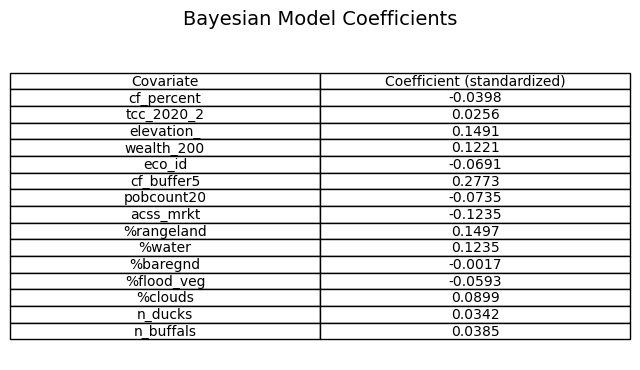

In [64]:
table_path = os.path.join('temp_files/report/', '15. Bayesian Coefficients.pdf')
title = 'Bayesian Model Coefficients'
functions.df_to_pdf(t9, table_path, title=title, show=True)